[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/YichenShen0103/CUMCM-25C/blob/main/problem4.ipynb)

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, PowerTransformer
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import requests
import os
from PIL import Image
from io import BytesIO
from IPython.display import display

import warnings

warnings.filterwarnings("ignore")

# 设置随机种子
np.random.seed(42)
torch.manual_seed(42)

In [2]:
# 读取数据
url = "https://raw.githubusercontent.com/YichenShen0103/CUMCM-25C/main/data/data.xlsx"
data = pd.read_excel(url, sheet_name=1)
data["class"] = data["染色体的非整倍体"].notna().astype(int)
weeks_days = data["检测孕周"].str.split(r"[wW]", expand=True)
data["孕天"] = weeks_days[0].astype(int) * 7 + weeks_days[1].fillna("0").replace(
    "", "0"
).astype(int)
data.drop("检测孕周", axis=1, inplace=True)

useless_columns = [
    "Unnamed: 20",
    "Unnamed: 21",
    "序号",
    "孕妇代码",
    "末次月经",
    "检测日期",
    "末次月经",
    "胎儿是否健康",
    "染色体的非整倍体",
    "IVF妊娠",
    "怀孕次数",
    "检测抽血次数",
]
data.drop(columns=useless_columns, inplace=True)
data.dropna(inplace=True)

X = data.drop(columns=["class"])
y = data["class"]

print(f"原始数据集形状: {X.shape}")
print(f"类别分布: {y.value_counts()}")

原始数据集形状: (604, 20)
类别分布: class
0    537
1     67
Name: count, dtype: int64


In [3]:
# 特征工程
def create_advanced_features(X):
    X_new = X.copy()

    # 添加特征交互
    feature_names = X.columns.tolist()
    for i in range(len(feature_names)):
        for j in range(i + 1, min(i + 5, len(feature_names))):  # 限制交互数量
            X_new[f"{feature_names[i]}_{feature_names[j]}_interaction"] = (
                X.iloc[:, i] * X.iloc[:, j]
            )

    # 添加多项式特征（选择重要特征）
    important_features = ["年龄", "孕天", "AFP_MOM", "Free_HCG_MOM", "Inhibin_A_MOM"]
    for feat in important_features:
        if feat in X.columns:
            X_new[f"{feat}_squared"] = X[feat] ** 2
            X_new[f"{feat}_log"] = np.log1p(np.abs(X[feat]))

    # 添加统计特征
    X_new["feature_sum"] = X.sum(axis=1)
    X_new["feature_mean"] = X.mean(axis=1)
    X_new["feature_std"] = X.std(axis=1)
    X_new["feature_skew"] = X.skew(axis=1)

    return X_new


# 应用特征工程
X_engineered = create_advanced_features(X)
print(f"特征工程后形状: {X_engineered.shape}")

# 使用PowerTransformer处理偏斜分布
transformer = PowerTransformer(method="yeo-johnson")
X_transformed = transformer.fit_transform(X_engineered)

# 标准化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_transformed)

# 数据分割
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.15, random_state=42, stratify=y
)

print(f"训练集形状: {X_train.shape}")
print(f"测试集形状: {X_test.shape}")

特征工程后形状: (604, 98)
训练集形状: (513, 98)
测试集形状: (91, 98)


In [4]:
# 神经网络
class SuperAdvancedClassifier(nn.Module):
    def __init__(self, input_dim):
        super(SuperAdvancedClassifier, self).__init__()

        # 多分支架构
        self.branch1 = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.2),
        )

        self.branch2 = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
        )

        # 注意力机制
        self.attention = nn.Sequential(
            nn.Linear(256 + 128, 64), nn.Tanh(), nn.Linear(64, 1), nn.Sigmoid()
        )

        # 最终分类器
        self.classifier = nn.Sequential(
            nn.Linear(256 + 128, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(64, 1),
        )

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.kaiming_uniform_(m.weight, nonlinearity="relu")
            nn.init.constant_(m.bias, 0)

    def forward(self, x):
        b1 = self.branch1(x)
        b2 = self.branch2(x)

        # 合并分支
        combined = torch.cat([b1, b2], dim=1)

        # 注意力权重
        attention_weights = self.attention(combined)
        attended = combined * attention_weights

        # 最终预测
        output = self.classifier(attended)
        return output

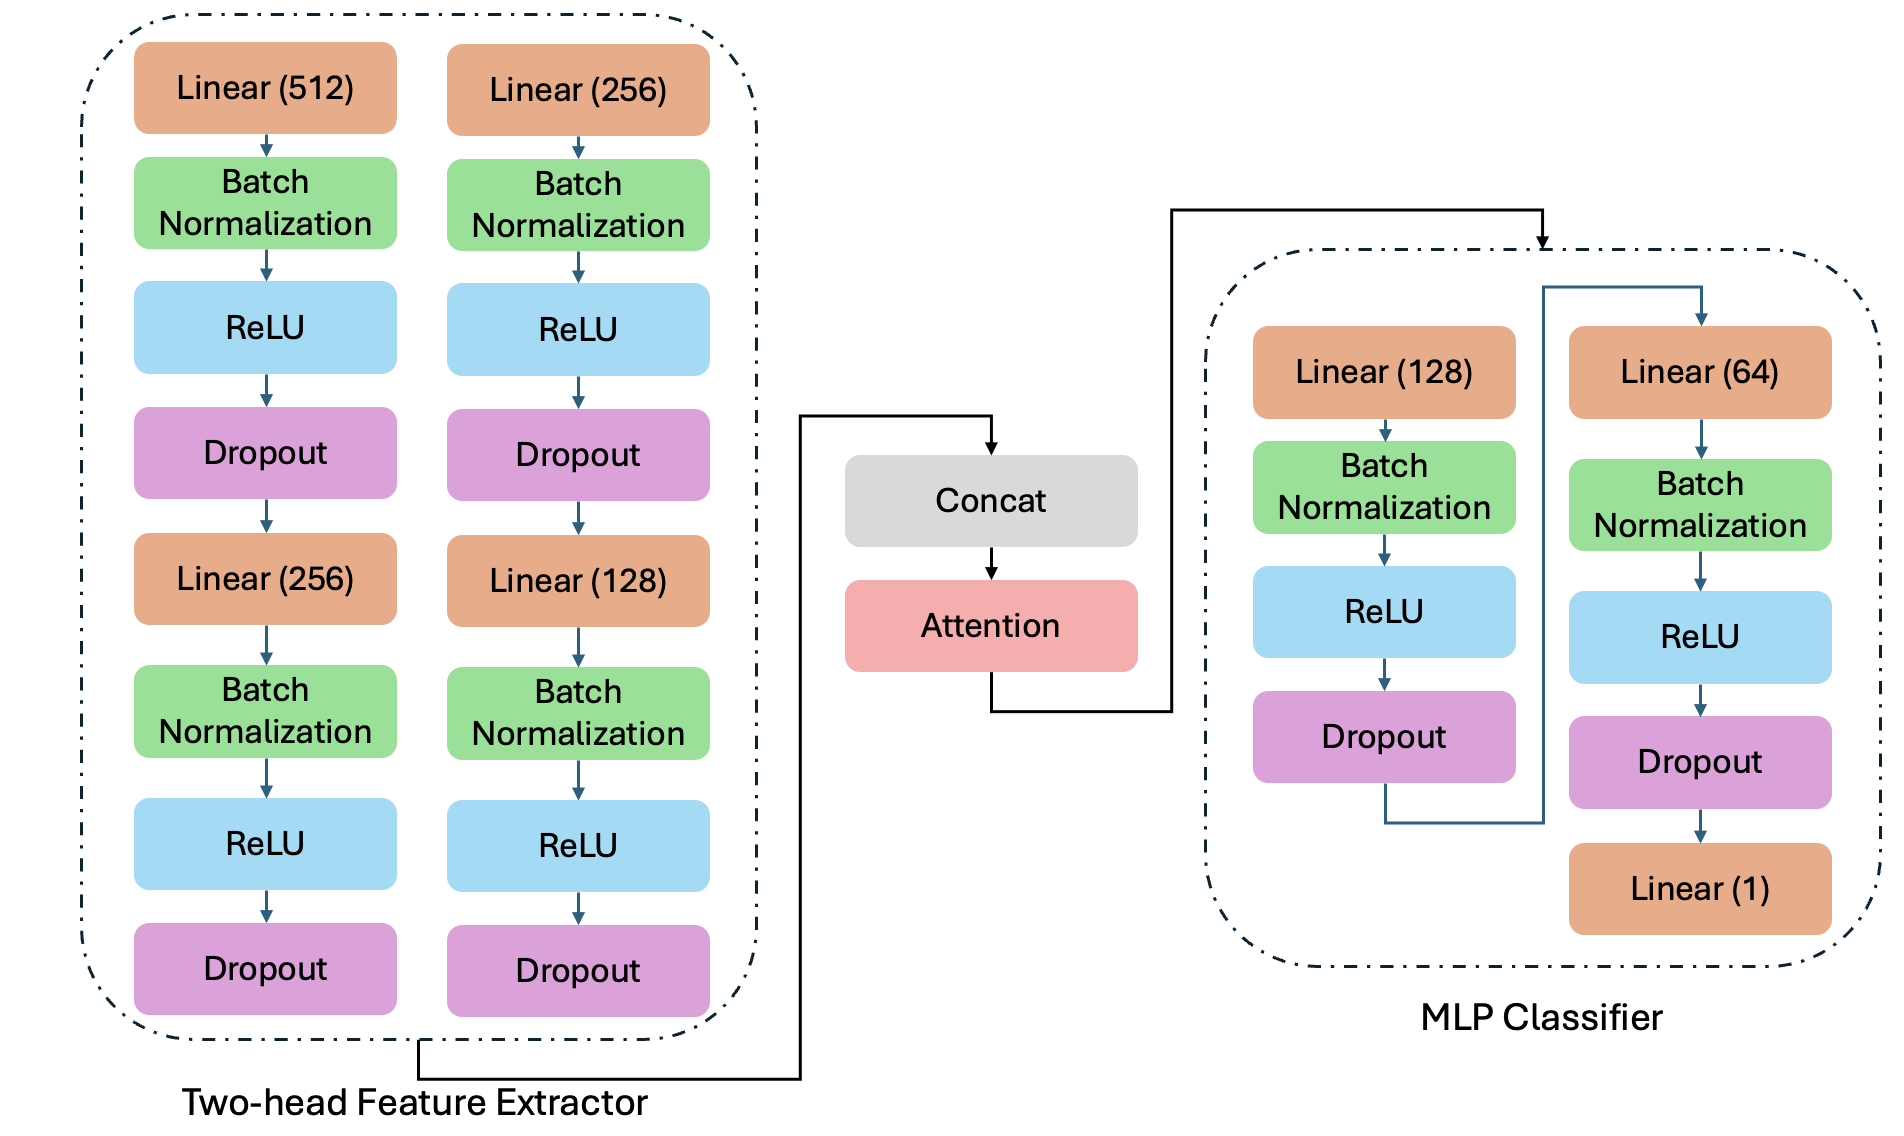

In [5]:
# 图片 URL
image_url = "https://raw.githubusercontent.com/YichenShen0103/CUMCM-25C/main/assets/model_pipeline.png"

# 从网络获取图片并转成二进制流
response = requests.get(image_url)
img = Image.open(BytesIO(response.content))

# 显示图片
display(img)

In [6]:
# 数据增强函数
def augment_minority_class(X, y, augment_factor=3):
    """通过添加噪声来增强少数类样本"""
    minority_indices = np.where(y == 1)[0]
    minority_X = X[minority_indices]

    augmented_X = []
    augmented_y = []

    for _ in range(augment_factor):
        # 添加高斯噪声
        noise = np.random.normal(0, 0.1, minority_X.shape)
        augmented_samples = minority_X + noise
        augmented_X.append(augmented_samples)
        augmented_y.extend([1] * len(minority_X))

    # 合并原始数据和增强数据
    X_augmented = np.vstack([X] + augmented_X)
    y_augmented = np.hstack([y, augmented_y])

    return X_augmented, y_augmented


# 应用数据增强
X_train_aug, y_train_aug = augment_minority_class(
    X_train, y_train.values, augment_factor=4
)
print(f"数据增强后训练集形状: {X_train_aug.shape}")
print(f"数据增强后类别分布: {np.unique(y_train_aug, return_counts=True)}")

数据增强后训练集形状: (741, 98)
数据增强后类别分布: (array([0, 1]), array([456, 285]))


In [7]:
# 训练超级模型
def train_super_model():
    # 转换为张量
    X_train_tensor = torch.tensor(X_train_aug, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train_aug, dtype=torch.float32).view(-1, 1)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

    # 创建数据加载器
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

    # 创建模型
    model = SuperAdvancedClassifier(X_train_tensor.shape[1])

    # 自适应损失函数
    class AdaptiveFocalLoss(nn.Module):
        def __init__(self, alpha=2, gamma=3):
            super(AdaptiveFocalLoss, self).__init__()
            self.alpha = alpha
            self.gamma = gamma

        def forward(self, inputs, targets):
            BCE_loss = F.binary_cross_entropy_with_logits(
                inputs, targets, reduction="none"
            )
            pt = torch.exp(-BCE_loss)

            # 动态调整alpha
            pos_weight = (targets == 0).sum().float() / (targets == 1).sum().float()
            alpha = torch.where(targets == 1, pos_weight, 1.0)

            F_loss = alpha * (1 - pt) ** self.gamma * BCE_loss
            return F_loss.mean()

    criterion = AdaptiveFocalLoss(alpha=3, gamma=4)
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-3)

    # 学习率调度器
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer, max_lr=0.01, epochs=15000, steps_per_epoch=len(train_loader)
    )

    best_accuracy = 0
    best_model_state = None
    patience_counter = 0
    patience = 1000

    for epoch in range(15000):
        model.train()
        total_loss = 0

        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
            optimizer.step()
            scheduler.step()
            total_loss += loss.item()

        # 验证
        if (epoch + 1) % 100 == 0:
            model.eval()
            with torch.no_grad():
                test_outputs = model(X_test_tensor)
                predicted_probs = torch.sigmoid(test_outputs)

                # 动态阈值优化
                thresholds = np.arange(0.3, 0.8, 0.05)
                best_threshold = 0.5
                best_acc = 0

                for threshold in thresholds:
                    predicted = (predicted_probs >= threshold).float()
                    acc = (
                        (predicted.squeeze() == y_test_tensor.squeeze()).sum().item()
                        / len(y_test)
                        * 100
                    )
                    if acc > best_acc:
                        best_acc = acc
                        best_threshold = threshold

                if best_acc > best_accuracy:
                    best_accuracy = best_acc
                    best_model_state = model.state_dict().copy()
                    patience_counter = 0
                else:
                    patience_counter += 100

                print(
                    f"Epoch [{epoch+1}/15000], Loss: {total_loss/len(train_loader):.4f}, "
                    f"Test Accuracy: {best_acc:.2f}% (threshold: {best_threshold:.2f}), "
                    f"Best: {best_accuracy:.2f}%"
                )

                if patience_counter >= patience:
                    print(f"Early stopping at epoch {epoch+1}")
                    break

    # 加载最佳模型
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        os.makedirs("model", exist_ok=True)
        torch.save(best_model_state, "model/best_model.pth")

    return model, best_accuracy


# 运行神经网络训练和评估
print("\n=== 训练超级神经网络 ===")
nn_model, nn_accuracy = train_super_model()


=== 训练超级神经网络 ===
Epoch [100/15000], Loss: 0.0074, Test Accuracy: 92.31% (threshold: 0.70), Best: 92.31%
Epoch [200/15000], Loss: 0.0017, Test Accuracy: 93.41% (threshold: 0.70), Best: 93.41%
Epoch [300/15000], Loss: 0.0010, Test Accuracy: 93.41% (threshold: 0.70), Best: 93.41%
Epoch [400/15000], Loss: 0.0005, Test Accuracy: 93.41% (threshold: 0.55), Best: 93.41%
Epoch [500/15000], Loss: 0.0002, Test Accuracy: 94.51% (threshold: 0.75), Best: 94.51%
Epoch [600/15000], Loss: 0.0001, Test Accuracy: 91.21% (threshold: 0.60), Best: 94.51%
Epoch [700/15000], Loss: 0.0017, Test Accuracy: 92.31% (threshold: 0.75), Best: 94.51%
Epoch [800/15000], Loss: 0.0002, Test Accuracy: 90.11% (threshold: 0.45), Best: 94.51%
Epoch [900/15000], Loss: 0.0004, Test Accuracy: 92.31% (threshold: 0.60), Best: 94.51%
Epoch [1000/15000], Loss: 0.0003, Test Accuracy: 92.31% (threshold: 0.60), Best: 94.51%
Epoch [1100/15000], Loss: 0.0001, Test Accuracy: 91.21% (threshold: 0.55), Best: 94.51%
Epoch [1200/15000], Los

In [8]:
# evaluate saved model
print("\n=== 评估保存的最佳模型 ===")
X_train_tensor = torch.tensor(X_train_aug, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_aug, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

# 创建模型
best_model = SuperAdvancedClassifier(X_train_tensor.shape[1])
best_model.load_state_dict(torch.load("model/best_model.pth"))
best_model.eval()
with torch.no_grad():
    test_outputs = best_model(X_test_tensor)
    predicted_probs = torch.sigmoid(test_outputs)

    # 动态阈值优化
    thresholds = np.arange(0.3, 0.8, 0.05)
    best_threshold = 0.5
    best_acc = 0
    for threshold in thresholds:
        predicted = (predicted_probs >= threshold).float()
        acc = (predicted.squeeze() == y_test.values).sum() / len(y_test.values) * 100
        print(f"Threshold: {threshold:.2f}, Accuracy: {acc:.2f}%")
        if acc > best_acc:
            best_acc = acc
            best_threshold = threshold

    predicted_final = (predicted_probs >= best_threshold).float()
    print(f"最终准确率: {best_acc:.2f}%, threshold: {best_threshold:.2f}")
    print(f"AUC Score: {roc_auc_score(y_test.values, predicted_probs.numpy()):.4f}")
    print("\n混淆矩阵:")
    print(confusion_matrix(y_test.values, predicted_final.numpy()))
    print("\n分类报告:")
    print(classification_report(y_test.values, predicted_final.numpy()))



=== 评估保存的最佳模型 ===
Threshold: 0.30, Accuracy: 83.52%
Threshold: 0.35, Accuracy: 84.62%
Threshold: 0.40, Accuracy: 85.71%
Threshold: 0.45, Accuracy: 85.71%
Threshold: 0.50, Accuracy: 87.91%
Threshold: 0.55, Accuracy: 89.01%
Threshold: 0.60, Accuracy: 89.01%
Threshold: 0.65, Accuracy: 90.11%
Threshold: 0.70, Accuracy: 91.21%
Threshold: 0.75, Accuracy: 91.21%
最终准确率: 91.21%, threshold: 0.70
AUC Score: 0.7926

混淆矩阵:
[[79  2]
 [ 6  4]]

分类报告:
              precision    recall  f1-score   support

           0       0.93      0.98      0.95        81
           1       0.67      0.40      0.50        10

    accuracy                           0.91        91
   macro avg       0.80      0.69      0.73        91
weighted avg       0.90      0.91      0.90        91

